# Goal
E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing money laundry, etc.
Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit card information has a risk team in charge of avoiding frauds via machine learning.
The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.


## Challenge Description
Company XYZ is an e-commerce site that sells hand-made clothes.
You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.
You only have information about the user first transaction on the site and based on that you have to make your classification ("fraud/no fraud").
These are the tasks you are asked to do:
1. For each user, determine her country based on the numeric IP address.


2. Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.


3. Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?


4. Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is,what kind of different user experiences would you build based on the model output?

In [80]:
import os
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [2]:
os.chdir('./4_identifying_fraudulent_activities/')
os.getcwd()

'/Users/guomeng/Documents/DS复习/Data Challenge/mine/4_identifying_fraudulent_activities'

In [20]:
df = pd.read_csv('./Fraud_Data.csv')
ip = pd.read_csv('./IpAddress_to_Country.csv')

In [4]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [6]:
df.shape, ip.shape

((151112, 11), (138846, 3))

In [7]:
df.isna().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [8]:
df.duplicated().any()

False

- ### 1. For each user, determine her country based on the numeric IP address.

In [9]:
len(np.unique(ip['country']))

235

In [10]:
countries = []
for i in range(len(df)):
    ip_address = df.loc[i, 'ip_address']
    tmp = ip[(ip['lower_bound_ip_address'] <= ip_address) &
                    (ip['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')

In [21]:
df['country'] = countries

In [22]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


- ### Build a model to predict whether an activity is fraudulent or not. 

Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

### Prepare date

In [23]:
df['interval'] = (pd.to_datetime(df['purchase_time']) - pd.to_datetime(df['signup_time'])).dt.total_seconds()

In [24]:
df['signup_days_of_year'] = pd.DatetimeIndex(df['signup_time']).dayofyear
df['purchase_days_of_year'] = pd.DatetimeIndex(df['purchase_time']).dayofyear

In [76]:
df['signup_seconds_of_day'] = pd.DatetimeIndex(df['signup_time']).second + 60 * pd.DatetimeIndex(
    df['signup_time']).minute + 3600 * pd.DatetimeIndex(df['signup_time']).hour
df['purchase_seconds_of_day'] = pd.DatetimeIndex(df['purchase_time']).second + 60 * pd.DatetimeIndex(
    df['purchase_time']).minute + 3600 * pd.DatetimeIndex(df['purchase_time']).hour
df_new = df.copy()
df_new.drop(['user_id','signup_time','purchase_time'], axis=1, inplace=True)

In [77]:
df_new.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval,signup_days_of_year,purchase_days_of_year,signup_seconds_of_day,purchase_seconds_of_day
0,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,55,108,82549,10031
1,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,158,159,74390,5934
2,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,1,1,67964,67965
3,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,118,124,76405,50090
4,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,202,252,25792,67253


### Visualization

In [42]:
non_fraud = df[df['class']==0]
fraud = df[df['class']==1]
non_fraud.shape, fraud.shape

((136961, 17), (14151, 17))

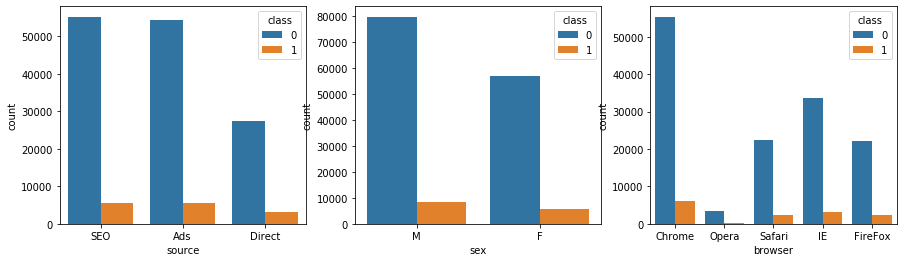

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
sns.countplot(x='source', hue='class', data=df, ax=ax[0])
sns.countplot(x='sex', hue='class', data=df, ax=ax[1])
sns.countplot(x='browser', hue='class', data=df, ax=ax[2])

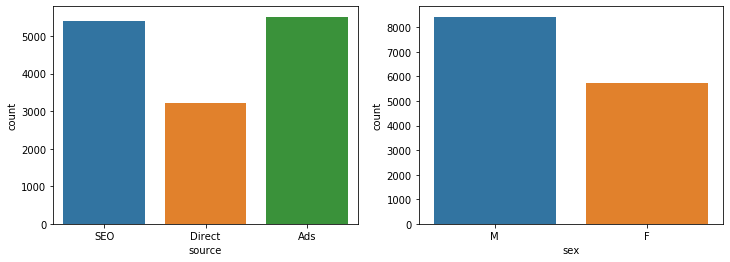

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.countplot(fraud['source'], ax=ax[0])
sns.countplot(fraud['sex'], ax=ax[1])

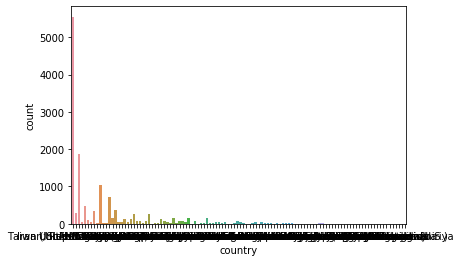

In [44]:
sns.countplot(fraud['country'])

,class,interval
0,0,5.191179e+06
1,1,2.423842e+06


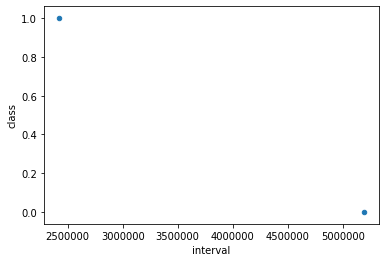

In [57]:
inter = df.groupby('class')['interval'].mean().reset_index()

inter.plot.scatter(x='interval', y='class')
inter

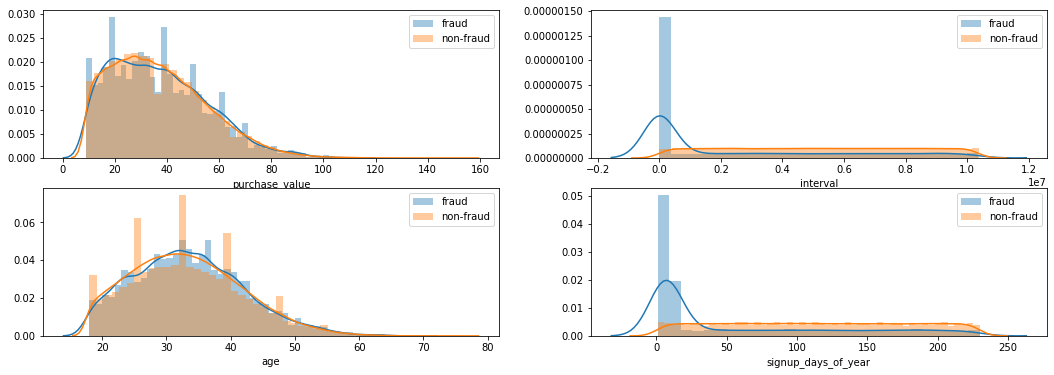

In [71]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,6))
#sns.distplot(df['purchase_value'], ax=ax[0])
sns.distplot(fraud['purchase_value'], ax=ax[0][0], label='fraud')
sns.distplot(non_fraud['purchase_value'], ax=ax[0][0], label='non-fraud')
sns.distplot(fraud['interval'], ax=ax[0][1], label='fraud')
sns.distplot(non_fraud['interval'], ax=ax[0][1], label='non-fraud')
sns.distplot(fraud['age'], ax=ax[1][0], label='fraud')
sns.distplot(non_fraud['age'], ax=ax[1][0], label='non-fraud')
sns.distplot(fraud['signup_days_of_year'], ax=ax[1][1], label='fraud')
sns.distplot(non_fraud['signup_days_of_year'], ax=ax[1][1], label='non-fraud')
ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()

### Deal with categorical features

In [89]:
len(np.unique(df['device_id']))

137956

In [90]:
df_new.drop('device_id', inplace=True, axis=1)
df_new.drop('ip_address', inplace=True, axis=1)

In [93]:
df_new.head()

,purchase_value,source,browser,sex,age,country,interval,signup_days_of_year,purchase_days_of_year,signup_seconds_of_day,purchase_seconds_of_day
0,34,SEO,Chrome,M,39,Japan,4506682.0,55,108,82549,10031
1,16,Ads,Chrome,F,53,United States,17944.0,158,159,74390,5934
2,15,SEO,Opera,M,53,United States,1.0,1,1,67964,67965
3,44,SEO,Safari,M,41,NA,492085.0,118,124,76405,50090
4,39,Ads,Safari,M,45,United States,4361461.0,202,252,25792,67253


In [94]:
# Categotical Features: source, browser, sex, country
len(np.unique(df['source'])), len(np.unique(df['browser'])), \
len(np.unique(df['sex'])), len(np.unique(df['country']))

(3, 5, 2, 182)

In [99]:
# Use one-hot encoding on first three
source = pd.get_dummies(df_new['source'])
browser = pd.get_dummies(df_new['browser'])
sex = pd.get_dummies(df_new['sex'])
df_new = pd.concat([df_new, source, browser, sex], axis=1)

df_new.drop(columns=['source', 'browser', 'sex', 'F'], inplace=True)

In [101]:
# the more a device is shared, the more suspicious
df_new['n_dev_shared'] = df.device_id.map(df.device_id.value_counts(dropna=False))

# the more a ip is shared, the more suspicious
df_new['n_ip_shared'] = df.ip_address.map(df.ip_address.value_counts(dropna=False))

# the less visit from a country, the more suspicious
df_new['n_country_shared'] = df.country.map(df.country.value_counts(dropna=False))

In [110]:
df_new.drop('country', axis=1, inplace=True)

In [102]:
df_new.head()

,purchase_value,age,country,interval,signup_days_of_year,purchase_days_of_year,signup_seconds_of_day,purchase_seconds_of_day,Ads,Direct,SEO,Chrome,FireFox,IE,Opera,Safari,M,n_dev_shared,n_ip_shared,n_country_shared
0,34,39,Japan,4506682.0,55,108,82549,10031,0,0,1,1,0,0,0,0,1,1,1,7306
1,16,53,United States,17944.0,158,159,74390,5934,1,0,0,1,0,0,0,0,0,1,1,58049
2,15,53,United States,1.0,1,1,67964,67965,0,0,1,0,0,0,1,0,1,12,12,58049
3,44,41,NA,492085.0,118,124,76405,50090,0,0,1,0,0,0,0,1,1,1,1,21966
4,39,45,United States,4361461.0,202,252,25792,67253,1,0,0,0,0,0,0,1,1,1,1,58049


### Prepare training and testing dataset

In [111]:
y = df_new['class']
df_new.drop(columns=['class'], inplace=True)
X = df_new.values

In [118]:
y

0         0
1         0
2         1
3         0
4         0
         ..
151107    1
151108    0
151109    0
151110    0
151111    0
Name: class, Length: 151112, dtype: int64

In [123]:
# Method 1: Direct use sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [113]:
# Method 2: Self-define function

def my_train_test_split(X, y, test_size=0.33, seed=42):
    X = pd.DataFrame(X)
    X_train = X.sample(frac=1-test_size, random_state=seed)
    X_test = X.drop(X_train.index)
    y_train = y.loc[X_train.index]
    y_test = y.drop(X_train.index)
    return X_train.values, y_train, X_test.values, y_test
X_train_my, y_train_my, X_test_my, y_test_my = my_train_test_split(X, y, test_size=0.33, seed=42)    

### Modeling

In [114]:
from sklearn.ensemble import RandomForestClassifier

In [115]:
rf = RandomForestClassifier()

In [127]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [129]:
# predict class labels 0/1 for the test set
predicted = rf.predict(X_test)

# generate class probabilities
probs = rf.predict_proba(X_test)

# generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, predicted)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0

accuracy_score is: : 0.9570256883309604
roc_auc_score is: : 0.8476446423649557
f1_score is: : 0.7014904582810977
confusion_matrix is: 
        pred_0  pred_1
true_0   45206      25
true_1    2118    2518
recall = 0.5431406384814496
precision = 0.9901690916240661


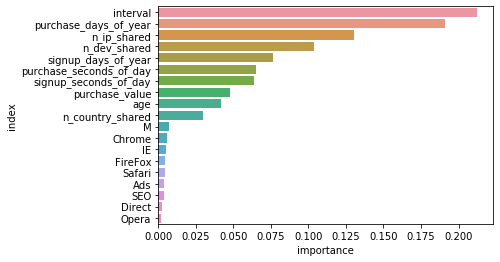

In [140]:
importance = pd.DataFrame(rf.feature_importances_, index = df_new.columns,\
                          columns=['importance']).sort_values('importance', ascending=False).reset_index()
sns.barplot(x='importance', y='index', data=importance)

In [173]:
# import xgboost as xgb
from xgboost import plot_importance
#XB = xgb.DMatrix(X_train, label=y_train, feature_names=df_new.columns)

GB = xgb.XGBClassifier(feature_names=df_new.columns)
GB.fit(X_train,y_train)
y_pred = GB.predict(X_train)


In [174]:
# predict class labels 0/1 for the test set
probs = GB.predict(X_test)
predicted = [1 if i>=0.5 else 0 for i in probs]

# generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, predicted)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, predicted)))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0

accuracy_score is: : 0.95738664848497
roc_auc_score is: : 0.7709121552981342
f1_score is: : 0.702755630158064
confusion_matrix is: 
        pred_0  pred_1
true_0   45230       1
true_1    2124    2512
recall = 0.5418464193270061
precision = 0.9996020692399522


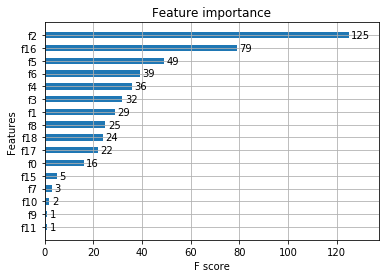

In [175]:
# show 20 most important features
GB.feature_names = df_new.columns
plot_importance(GB,height=0.5,max_num_features=20)
plt.show()

In [176]:
df_new.columns

Index(['purchase_value', 'age', 'interval', 'signup_days_of_year',
       'purchase_days_of_year', 'signup_seconds_of_day',
       'purchase_seconds_of_day', 'Ads', 'Direct', 'SEO', 'Chrome', 'FireFox',
       'IE', 'Opera', 'Safari', 'M', 'n_dev_shared', 'n_ip_shared',
       'n_country_shared'],
      dtype='object')

In [177]:
GB.feature_importances_

array([3.0759936e-03, 2.2982133e-03, 7.5506514e-01, 2.7912632e-03,
       3.4262210e-03, 3.5204568e-03, 3.4830242e-03, 2.6646323e-04,
       2.2024622e-02, 2.8060887e-03, 8.3574569e-03, 4.1606054e-03,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.8528124e-03,
       1.6471851e-01, 1.8351564e-02, 2.8016169e-03], dtype=float32)

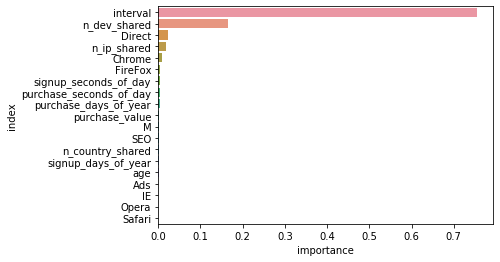

In [179]:
importance = pd.DataFrame(GB.feature_importances_, GB.feature_names,\
                          columns=['importance']).sort_values('importance', ascending=False).reset_index()
sns.barplot(x='importance', y='index', data=importance)